In [1]:
import os
import uproot
import numpy as np
import pandas as pd
import awkward as ak

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    't5_innerRadius',
    't5_bridgeRadius',
    't5_outerRadius',
    't5_pt',
    't5_eta',
    't5_phi',
    't5_isFake',
    't5_t3_idx0',
    't5_t3_idx1',
]

# Hit-dependent branches
suffixes = ['r', 'z', 'eta', 'phi', 'layer']
branches_list += [f't5_t3_{i}_{suffix}' for i in [0, 2, 4] for suffix in suffixes]

file_path = "1000_no_radii_new.root"
branches = load_root_file(file_path, branches_list)

/tmp/ipykernel_1544295/523946210.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
z_max = np.max([np.max(event) for event in branches[f't5_t3_4_z']])
r_max = np.max([np.max(event) for event in branches[f't5_t3_4_r']])
eta_max = 2.5

print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

Z max: 267.2349853515625, R max: 110.10993957519531, Eta max: 2.5


In [3]:
features_list = []

for event in range(branches['event']):
    # Determine the number of elements in this event
    num_elements = len(branches['t5_t3_idx0'][event])

    for i in range(num_elements):
        features_iter = []
        
        idx0 = branches['t5_t3_idx0'][event][i]
        idx1 = branches['t5_t3_idx1'][event][i]

        # Collect features using idx0
        features_iter.extend([
            np.abs(branches['t5_t3_0_eta'][event][idx0]) / eta_max,
            np.abs(branches['t5_t3_0_z'][event][idx0]) / z_max,
            branches['t5_t3_0_r'][event][idx0] / r_max,
            np.abs(branches['t5_t3_2_eta'][event][idx0]) - np.abs(branches['t5_t3_0_eta'][event][idx0]),
            (np.abs(branches['t5_t3_2_z'][event][idx0]) - np.abs(branches['t5_t3_0_z'][event][idx0])) / z_max,
            (branches['t5_t3_2_r'][event][idx0] - branches['t5_t3_0_r'][event][idx0]) / r_max,
            np.abs(branches['t5_t3_4_eta'][event][idx0]) - np.abs(branches['t5_t3_2_eta'][event][idx0]),
            (np.abs(branches['t5_t3_4_z'][event][idx0]) - np.abs(branches['t5_t3_2_z'][event][idx0])) / z_max,
            (branches['t5_t3_4_r'][event][idx0] - branches['t5_t3_2_r'][event][idx0]) / r_max,
        ])
        
        # Collect features using idx1
        features_iter.extend([
            np.abs(branches['t5_t3_2_eta'][event][idx1]) - np.abs(branches['t5_t3_4_eta'][event][idx0]),
            (np.abs(branches['t5_t3_2_z'][event][idx1]) - np.abs(branches['t5_t3_4_z'][event][idx0])) / z_max,
            (branches['t5_t3_2_r'][event][idx1] - branches['t5_t3_4_r'][event][idx0]) / r_max,
            np.abs(branches['t5_t3_4_eta'][event][idx1]) - np.abs(branches['t5_t3_2_eta'][event][idx1]),
            (np.abs(branches['t5_t3_4_z'][event][idx1]) - np.abs(branches['t5_t3_2_z'][event][idx1])) / z_max,
            (branches['t5_t3_4_r'][event][idx1] - branches['t5_t3_2_r'][event][idx1]) / r_max,
        ])
        
        # Add remaining features
        features_iter.extend([
            np.log10(branches['t5_innerRadius'][event][i]),
            np.log10(branches['t5_bridgeRadius'][event][i]),
            np.log10(branches['t5_outerRadius'][event][i]),
        ])
        
        # Append the feature vector to the list
        features_list.append(features_iter)

# Convert the list of features to a NumPy array
features = np.array(features_list).T

In [4]:
import torch

# Stack features along a new axis to form a single array suitable for NN input
input_features_numpy = np.stack(features, axis=-1)

# Identify rows with NaN or Inf values
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)

# Apply mask across all columns: retain a row only if all its entries are neither NaN nor Inf
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
t5_isFake_filtered = np.concatenate(branches['t5_isFake'])[np.all(mask, axis=1)]

# Convert to PyTorch tensor when ready to use with NN
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

In [5]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

# Initialize model, loss function, and optimizer
model = MyNeuralNetwork().to(device)
loss_function = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.0025)

labels_tensor = 1 - torch.tensor(t5_isFake_filtered, dtype=torch.float32)

# Remove rows with NaN in input_features_tensor and corresponding labels
nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]

# Get indices of each class
class_zero_indices = (filtered_labels == 0).nonzero(as_tuple=True)[0]
class_one_indices = (filtered_labels == 1).nonzero(as_tuple=True)[0]

print(np.shape(class_zero_indices), np.shape(class_one_indices))

# Randomly sample from the majority class to match the number of samples in the minority class
undersampled_class_one_indices = class_one_indices[torch.randperm(len(class_one_indices))[:len(class_zero_indices)]]

# Combine the minority class indices with the downsampled majority class indices
undersampled_indices = torch.cat((class_zero_indices, undersampled_class_one_indices), dim=0)

# Create new dataset with undersampled indices
undersampled_dataset = TensorDataset(filtered_inputs[undersampled_indices], filtered_labels[undersampled_indices])

total_count = len(undersampled_dataset)
train_count = int(0.8 * total_count)  # 80% for training
test_count = total_count - train_count  # Remaining 20% for testing

train_dataset, test_dataset = random_split(undersampled_dataset, [train_count, test_count])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=10, pin_memory=True)
loss_log = []

def evaluate_model(loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += targets.size(0)
            correct += (predicted == targets.bool()).sum().item()
    model.train()
    return 100 * correct / total

# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
    
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs.squeeze(), targets)

        loss_log.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_accuracy = evaluate_model(train_loader)
    test_accuracy = evaluate_model(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

Using device: cuda
torch.Size([2403894]) torch.Size([7404776])
Epoch [1/150], Loss: 0.5139, Train Acc: 81.34%, Test Acc: 81.39%
Epoch [2/150], Loss: 0.4514, Train Acc: 82.29%, Test Acc: 82.31%
Epoch [3/150], Loss: 0.5008, Train Acc: 82.32%, Test Acc: 82.36%
Epoch [4/150], Loss: 0.3863, Train Acc: 82.27%, Test Acc: 82.29%
Epoch [5/150], Loss: 0.2712, Train Acc: 82.03%, Test Acc: 82.06%
Epoch [6/150], Loss: 0.3863, Train Acc: 83.07%, Test Acc: 83.08%
Epoch [7/150], Loss: 0.3750, Train Acc: 82.58%, Test Acc: 82.59%
Epoch [8/150], Loss: 0.4049, Train Acc: 83.46%, Test Acc: 83.50%
Epoch [9/150], Loss: 0.4032, Train Acc: 83.35%, Test Acc: 83.36%
Epoch [10/150], Loss: 0.3225, Train Acc: 83.40%, Test Acc: 83.45%
Epoch [11/150], Loss: 0.4210, Train Acc: 83.55%, Test Acc: 83.55%
Epoch [12/150], Loss: 0.3300, Train Acc: 83.87%, Test Acc: 83.91%
Epoch [13/150], Loss: 0.3316, Train Acc: 83.37%, Test Acc: 83.40%
Epoch [14/150], Loss: 0.3970, Train Acc: 83.84%, Test Acc: 83.85%
Epoch [15/150], Loss: 

In [6]:
torch.save(model.state_dict(), "model.pth")

In [7]:
from sklearn.metrics import accuracy_score

# Convert tensors to numpy for simplicity in permutation
input_features_np = input_features_tensor.numpy()
labels_np = labels_tensor.numpy()

def model_accuracy(features, labels, model):
    model.eval()  # Set the model to evaluation mode
    inputs = features.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()  # Update threshold as necessary
        accuracy = (predicted == labels).float().mean().item()
    return accuracy

# Use the original input_features_tensor and labels_tensor directly
baseline_accuracy = model_accuracy(input_features_tensor, labels_tensor, model)
print(f"Baseline accuracy: {baseline_accuracy}")

# Initialize an array to store feature importances
feature_importances = np.zeros(input_features_tensor.shape[1])

# Permute each feature and calculate the drop in accuracy
for i in range(input_features_tensor.shape[1]):
    permuted_features = input_features_tensor.clone()
    permuted_features[:, i] = permuted_features[torch.randperm(permuted_features.size(0)), i]  # Permute feature

    permuted_accuracy = model_accuracy(permuted_features, labels_tensor, model)
    feature_importances[i] = baseline_accuracy - permuted_accuracy

# Ranking features by importance
important_features_indices = np.argsort(feature_importances)[::-1]  # Indices of features in descending importance
important_features_scores = np.sort(feature_importances)[::-1]  # Importance scores in descending order

print("Feature importances:")
for idx, score in zip(important_features_indices, important_features_scores):
    print(f"Feature {idx} importance: {score:.4f}")

Baseline accuracy: 0.8330265879631042
Feature importances:
Feature 16 importance: 0.3972
Feature 15 importance: 0.3339
Feature 17 importance: 0.2924
Feature 1 importance: 0.2358
Feature 0 importance: 0.1953
Feature 9 importance: 0.1603
Feature 12 importance: 0.1093
Feature 6 importance: 0.0758
Feature 4 importance: 0.0669
Feature 3 importance: 0.0547
Feature 7 importance: 0.0404
Feature 2 importance: 0.0281
Feature 11 importance: 0.0193
Feature 14 importance: 0.0134
Feature 5 importance: 0.0115
Feature 10 importance: 0.0108
Feature 13 importance: 0.0090
Feature 8 importance: 0.0070


/tmp/ipykernel_1544295/52354147.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


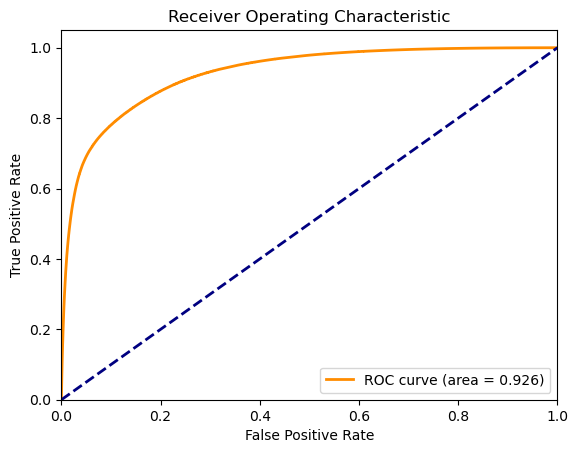

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def model_outputs(features, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(features, dtype=torch.float32).to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
    return outputs

# Calculate model outputs
probabilities = model_outputs(filtered_inputs, model)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(filtered_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
# Make sure the model is in evaluation mode
model.eval()

# Accessing weights and biases for layer1
layer1_weights = model.layer1.weight.data.cpu().numpy()
layer1_biases = model.layer1.bias.data.cpu().numpy()

# Accessing weights and biases for layer2
layer2_weights = model.layer2.weight.data.cpu().numpy()
layer2_biases = model.layer2.bias.data.cpu().numpy()

# Accessing weights and biases for output_layer
output_layer_weights = model.output_layer.weight.data.cpu().numpy()
output_layer_biases = model.output_layer.bias.data.cpu().numpy()

def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()  # New line for better readability

    # Print weights
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()  # New line for better readability


print_formatted_weights_biases(layer1_weights, layer1_biases, "0")
print_formatted_weights_biases(layer2_weights, layer2_biases, "2")
print_formatted_weights_biases(output_layer_weights, output_layer_biases, "4")

ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_0[32] = {
-0.1499876f, -0.0476954f, 0.0072908f, -0.1131159f, 1.0607450f, 0.9512361f, -0.2171159f, -0.0891951f, 1.9543512f, -0.0410189f, 0.2051593f, -0.1441609f, 0.0220265f, 0.0061414f, -1.2668802f, 1.2290764f, 0.1718124f, 1.6923177f, 1.3287535f, -0.2312031f, -0.6576020f, -0.2982113f, 0.0119458f, -0.3674974f, 1.2777895f, -0.1650601f, 0.0937916f, -0.0485528f, -0.0759638f, -0.0541043f, -0.5819769f, -0.1176922f };

ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_0[18][32] = {
{ -0.0887985f, -0.1118124f, 0.1868948f, 0.0678084f, 0.2205922f, -1.4321359f, -0.2070529f, 0.0343634f, 0.4204769f, -0.1326087f, -0.1286474f, 0.1540338f, -0.2705165f, -0.1516614f, -0.2397254f, -1.2568928f, 0.0080059f, -0.0119017f, 1.3024874f, -0.2287283f, 2.8337271f, -0.3037449f, -0.5350525f, 0.1041258f, 0.7305318f, -0.1011182f, -0.1653814f, -0.2167438f, -0.0909145f, -0.0807109f, 0.5774108f, -0.1784460f },
{ -0.0280668f, -0.0727316f, 0.0250515f, -0.0043019f, -0.8932780f, -0.50